Balanced Logistic Regression Accuracy: 0.6751918158567775
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       328
           1       0.25      0.51      0.34        63

    accuracy                           0.68       391
   macro avg       0.57      0.61      0.56       391
weighted avg       0.78      0.68      0.71       391

[[232  96]
 [ 31  32]]
AUC: 0.69579945799458
Gradient Boosting Accuracy: 0.8235294117647058
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       328
           1       0.33      0.10      0.15        63

    accuracy                           0.82       391
   macro avg       0.59      0.53      0.52       391
weighted avg       0.76      0.82      0.78       391

[[316  12]
 [ 57   6]]
AUC: 0.6574235385210995


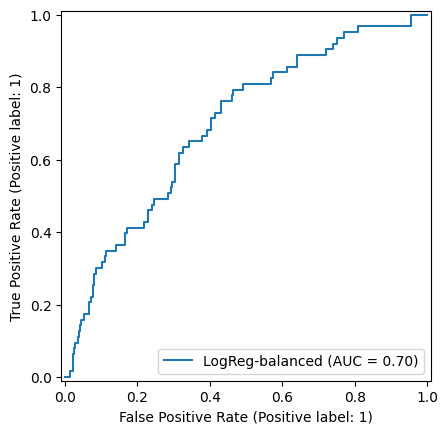

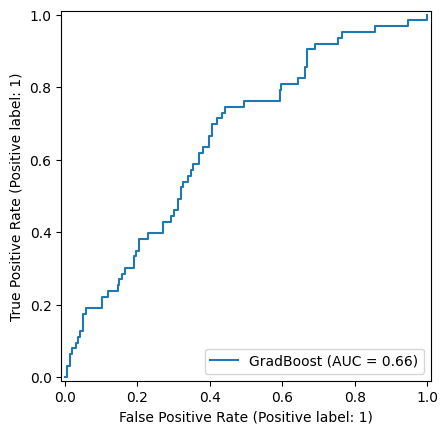

In [1]:
# Try two strategies to improve minority (Senior) recall: 
# 1) Logistic regression with class_weight='balanced'
# 2) Gradient Boosting classifier with class_weight set via sample_weight

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Load data
train_df = pd.read_csv('Train_Data.csv', encoding='ascii')
train_df = train_df.dropna(subset=['age_group']).copy()

# Feature engineering
train_df['BMI_GLU'] = train_df['BMXBMI'] * train_df['LBXGLU']
train_df['IN_GLU_RATIO'] = train_df['LBXIN'] / train_df['LBXGLU']
train_df['age_group'] = train_df['age_group'].map({'Adult':0, 'Senior':1})

cat_cols = ['RIAGENDR', 'PAQ605', 'DIQ010']
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN', 'BMI_GLU', 'IN_GLU_RATIO']

X = train_df[cat_cols + num_cols]
y = train_df['age_group']

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)])

# 1. Balanced Logistic Regression
pipe_lr = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
cr_lr = classification_report(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1])

print('Balanced Logistic Regression Accuracy:', acc_lr)
print(cr_lr)
print(cm_lr)
print('AUC:', auc_lr)

# 2. Gradient Boosting
pipe_gb = Pipeline([
    ('prep', preprocessor),
    ('clf', GradientBoostingClassifier())])

pipe_gb.fit(X_train, y_train)

y_pred_gb = pipe_gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
cr_gb = classification_report(y_test, y_pred_gb)
cm_gb = confusion_matrix(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, pipe_gb.predict_proba(X_test)[:,1])

print('Gradient Boosting Accuracy:', acc_gb)
print(cr_gb)
print(cm_gb)
print('AUC:', auc_gb)

# ROC curves
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test, name='LogReg-balanced')
RocCurveDisplay.from_estimator(pipe_gb, X_test, y_test, name='GradBoost')
plt.show()

In [2]:
test_df=pd.read_csv('Test_Data.csv', encoding='ascii')
test_df['BMI_GLU'] = test_df['BMXBMI'] * test_df['LBXGLU']
test_df['IN_GLU_RATIO'] = test_df['LBXIN'] / test_df['LBXGLU']
X_test_final = test_df[cat_cols + num_cols]
# Predict on the final test set (pipeline handles preprocessing)
y_test_final_lr = pipe_lr.predict(X_test_final)
y_test_final_gb = pipe_gb.predict(X_test_final)
# Save predictions
test_df['Predicted_Age_Group_LR'] = y_test_final_lr
test_df['Predicted_Age_Group_GB'] = y_test_final_gb
test_df[['Predicted_Age_Group_LR']].to_csv('Test_Predictions(1).csv', index=False)



